```{currentmodule} tskit
```

(sec_tskit_r)=

# Tskit and R

To interface with `tskit` in R, we can use the [reticulate](https://rstudio.github.io/reticulate/) R package, which lets you call Python functions within an R session. In this tutorial, we'll go through a couple of examples to show you how to get started. If you haven't done so already, you'll need to install `reticulate` in your R session via `install.packages("reticulate")`. 

We'll begin by simulating a small tree sequence using `msprime`.

In [1]:
msprime <- reticulate::import("msprime")

ts <- msprime$sim_ancestry(80, sequence_length=1e4, recombination_rate=1e-4, random_seed=42)
ts  # See "Jupyter notebook tips", below for how to render this nicely

╔═══════════════════════════╗
║TreeSequence               ║
╠═══════════════╤═══════════╣
║Trees          │         26║
╟───────────────┼───────────╢
║Sequence Length│      10000║
╟───────────────┼───────────╢
║Time Units     │generations║
╟───────────────┼───────────╢
║Sample Nodes   │        160║
╟───────────────┼───────────╢
║Total Size     │   29.0 KiB║
╚═══════════════╧═══════════╝
╔═══════════╤════╤═════════╤════════════╗
║Table      │Rows│Size     │Has Metadata║
╠═══════════╪════╪═════════╪════════════╣
║Edges      │ 414│ 12.9 KiB│          No║
╟───────────┼────┼─────────┼────────────╢
║Individuals│  80│  2.2 KiB│          No║
╟───────────┼────┼─────────┼────────────╢
║Migrations │   0│  8 Bytes│          No║
╟───────────┼────┼─────────┼────────────╢
║Mutations  │   0│ 16 Bytes│          No║
╟───────────┼────┼─────────┼────────────╢
║Nodes      │ 344│  9.4 KiB│          No║
╟───────────┼────┼─────────┼────────────╢
║Populations│   1│224 Bytes│         Yes║
╟───────────┼────┼────

## Attributes and methods

`reticulate` allows us to access a Python object's attributes via
the `$` operator. For example, we can access (and assign to a variable) the number of
samples in the tree sequence:

In [2]:
n <- ts$num_samples
n

[1] 160

The `$` operator can also be used to call methods, for example, the 
{meth}`~TreeSequence.simplify` method associated with the tree sequence.
The method parameters are given as native R objects
(but note that object IDs still use tskit's 0-based indexing system).

In [3]:
reduced_ts <- ts$simplify(0:7)  # only keep samples with ids 0, 1, 2, 3, 4, 5, 6, 7
reduced_ts <- reduced_ts$delete_intervals(list(c(6000, 10000)))  # delete data after 6kb
reduced_ts <- reduced_ts$trim()  # remove the deleted region
paste(
    "Reduced from", ts$num_trees, "trees over", ts$sequence_length/1e3, "kb to",
    reduced_ts$num_trees, "trees over", reduced_ts$sequence_length/1e3, "kb.")

[1] "Reduced from 26 trees over 10 kb to 6 trees over 6 kb."

### IDs and indexes

Note that if a bare digit is provided to one of these methods, it will be treated as a
floating point number. This is useful to know when calling `tskit` methods that
require integers (e.g. object IDs). For example, the following will not work:

In [4]:
ts$node(0)  # Will raise an error

ERROR: Error in py_call_impl(callable, dots$args, dots$keywords): TypeError: Index must be of integer type, not 'float'

Detailed traceback:
  File "/opt/hostedtoolcache/Python/3.10.9/x64/lib/python3.10/site-packages/tskit/trees.py", line 5916, in node
    id_ = self.check_index(id_, self.num_nodes)
  File "/opt/hostedtoolcache/Python/3.10.9/x64/lib/python3.10/site-packages/tskit/trees.py", line 5937, in check_index
    raise TypeError(



In this case, to force the `0` to be passed as an integer, you can either coerce it
using `as.integer` or simply prepend the letter `L`:

In [5]:
ts$node(as.integer(0))
# or
ts$node(0L)

Node(id=0, flags=1, time=0.0, population=0, individual=0, metadata=b'')

Node(id=0, flags=1, time=0.0, population=0, individual=0, metadata=b'')

Coercing in this way is only necessary when passing parameters to those underlying
`tskit` methods that expect integers. It is not needed e.g. to index into numeric arrays.
_However_, when using arrays, very careful attention must be paid to the fact that
`tskit` IDs start at zero, whereas R indexes start at one:

In [6]:
root_id <- ts$first()$root
paste("Root time via tskit method:", ts$node(root_id)$time)
# When indexing into tskit arrays in R, add 1 to the ID
paste("Root time via array access:", ts$nodes_time[root_id + 1])

[1] "Root time via tskit method: 3.4634393266485"

[1] "Root time via array access: 3.4634393266485"

## Analysis

From within R we can use `tskit`'s powerful
[Statistics](https://tskit.dev/tskit/docs/stable/stats.html) framework to efficiently
compute many different summary statistics from a tree sequence. To illustrate this,
we'll first add some mutations to our tree sequence with the
{func}`msprime:msprime.sim_mutations` function, and then compute the genetic diversity
for each of the tree sequence's sample nodes:

In [7]:
ts_mut = msprime$sim_mutations(reduced_ts, rate=1e-4, random_seed=321)

paste(ts_mut$num_mutations, "mutations, genetic diversity is", ts_mut$diversity())

[1] "13 mutations, genetic diversity is 0.000720238095238095"

Numerical arrays and matrices work as expected. For instance, we can use the tree
sequence {meth}`~TreeSequence.genotype_matrix()` method to return the genotypes of
the tree sequence as a matrix object in R.

In [8]:
G = ts_mut$genotype_matrix()
G

0,0,0,1,0,0,0,0
0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0
0,0,1,0,0,0,0,0
0,0,1,1,0,1,1,0
0,1,1,1,0,1,1,0
0,1,1,1,1,1,1,1
0,1,1,1,1,1,1,1
1,0,0,0,0,0,0,0
0,0,0,0,1,0,0,1
1,0,0,0,0,0,0,0


We can then use R functions directly on the genotype matrix:

In [9]:
allele_frequency = rowMeans(G)
allele_frequency

[1] 0.125 0.125 0.125 0.125 0.500 0.625 0.875 0.875 0.125 0.250 0.125 0.625
[13] 0.125

## Jupyter notebook tips

When running R within a [Jupyter notebook](https://jupyter.org), a few magic functions
can be defined that allow tskit objects to be rendered within the notebook:

In [10]:
# Define some magic functions to allow objects to be displayed in R Jupyter notebooks
repr_html.tskit.trees.TreeSequence <- function(obj, ...){obj$`_repr_html_`()}
repr_html.tskit.trees.Tree <- function(obj, ...){obj$`_repr_html_`()}
repr_svg.tskit.drawing.SVGString <- function(obj, ...){obj$`__str__`()}

This leads to much nicer tabular summaries:

In [11]:
ts_mut

╔═══════════════════════════╗
║TreeSequence               ║
╠═══════════════╤═══════════╣
║Trees          │          6║
╟───────────────┼───────────╢
║Sequence Length│       6000║
╟───────────────┼───────────╢
║Time Units     │generations║
╟───────────────┼───────────╢
║Sample Nodes   │          8║
╟───────────────┼───────────╢
║Total Size     │    6.0 KiB║
╚═══════════════╧═══════════╝
╔═══════════╤════╤═════════╤════════════╗
║Table      │Rows│Size     │Has Metadata║
╠═══════════╪════╪═════════╪════════════╣
║Edges      │  32│  1.0 KiB│          No║
╟───────────┼────┼─────────┼────────────╢
║Individuals│   4│136 Bytes│          No║
╟───────────┼────┼─────────┼────────────╢
║Migrations │   0│  8 Bytes│          No║
╟───────────┼────┼─────────┼────────────╢
║Mutations  │  13│497 Bytes│          No║
╟───────────┼────┼─────────┼────────────╢
║Nodes      │  20│568 Bytes│          No║
╟───────────┼────┼─────────┼────────────╢
║Populations│   1│224 Bytes│         Yes║
╟───────────┼────┼─────────┼────────────╢
║Provenances│   5│  3.0 KiB│          No║
╟───────────┼────┼─────────┼────────────╢
║Sites      │  13│341 Bytes│          No║
╚═══════════╧════╧═════════╧════════════╝

It also allows trees and tree sequences to be plotted inline:

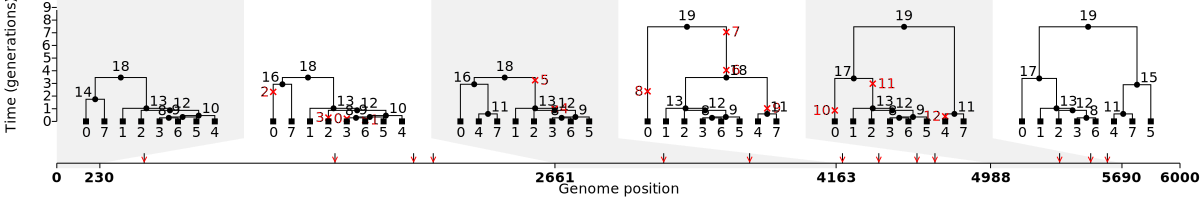

In [12]:
ts_mut$draw_svg(y_axis=TRUE, y_ticks=0:10)

## Interaction with R libraries

R has a number of libraries to deal with genomic data and trees. Below we focus on the
phylogenetic tree representation defined in the the popular
[ape](http://ape-package.ird.fr) package, taking all the trees
{meth}`exported in Nexus format<TreeSequence.write_nexus>`, or
individual trees {meth}`exported in Newick format<Tree.as_newick>`:

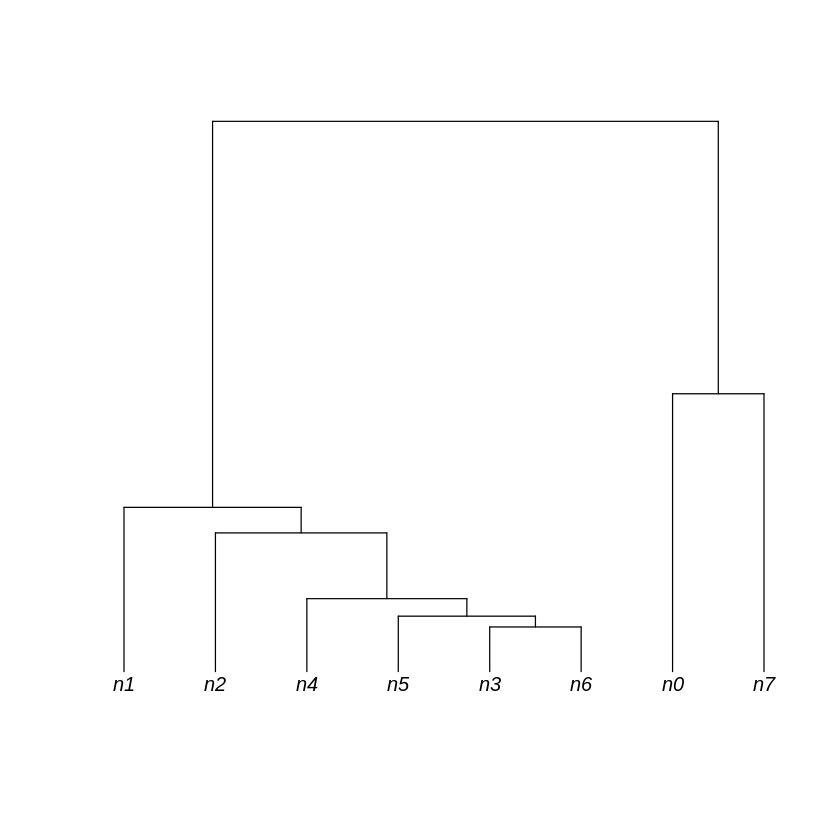

In [13]:
file = tempfile()
ts_mut$write_nexus(file)
# Warning - ape trees are stored independently, so this will use much more memory than tskit
trees <- ape::read.nexus(file, force.multi = TRUE)  # return a set of trees

# Or simply read in a single tree
tree <- ape::read.tree(text=ts_mut$first()$as_newick())

# Now we can plot the tree in tskit style, but using the ape library
plot(tree, direction="downward", srt=90, adj=0.5)  # or equivalently use trees[[1]]

Note that nodes are labelled with the prefix `n`, so that nodes `0`, `1`, `2`, ...
become `n0`, `n1`, `n2` ... etc. This helps to avoid
confusion between the the zero-based counting system used natively
by `tskit`, and the one-based counting system used in `R`.

## Further information

Be sure to check out the [reticulate](https://rstudio.github.io/reticulate/)
documentation, in particular on
[Calling Python from R](https://rstudio.github.io/reticulate/articles/calling_python.html),
which includes important information on how R data types are converted to their
equivalent Python types.